## Data processing and forming dataset meta

#### Guidelines for installing the necessary libraries

In our implementation we use pytorch3d version 0.7.5, which requires Python version from 3.8 up to 3.10. You could use a newer version of Python, but it will require some additional libraries to compile, like cuda-toolkit.

First, make sure you have installed one of the latest drivers; otherwise you can have problems with GPU availability with the PyTorch library. You should pay attention to the CUDA version of your installed driver. Your GPU's CUDA version must be equal to or greater than the CUDA version required by PyTorch. We strongly recommend using a GPU with the given code. You can check your version with this command:

In [1]:
!nvidia-smi

For PyTorch follow the instructions here https://pytorch.org/get-started/locally/. If you are planning to build pythorch3d library for an unsupported version of Python, make sure you download the same version of Cuda Toolkit as your installed PyTorch library supports. The Cuda toolkit can be downloaded here https://developer.nvidia.com/cuda-toolkit-archive/.

Before we can install pytorch3d we need to install some additional libraries. Here we will install all necessary libraries for our code:

In [2]:
%pip install torchinfo scipy seaborn scikit-learn pandas matplotlib k3d ipywidgets watermark ipykernel pyproject.toml wheel

For pytorch3d there are many ways to install it. We went with the one that is supported for Windows. For other ways of installation, you can check here https://github.com/facebookresearch/pytorch3d?tab=readme-ov-file#installation.

If you are installing it under Windows, you will also need Git, can be accessed here https://git-scm.com/download/win, and C++ Build Tools, which can be accessed here https://visualstudio.microsoft.com/visual-cpp-build-tools/. In C++ Build Tools, make sure to check and install "Desktop development with C++". You might need to reboot or close the current terminal in order for Git's path to be updated.

After that we can install pytorch3d from git:

In [3]:
%pip install "git+https://github.com/facebookresearch/pytorch3d.git@stable"

Building pytorch3d with the upper command took around 8 minutes to complete on Ryzen 7.

#### Libraries

In [ ]:
import os
import numpy as np
import copy
import csv
import pandas as pd
from datetime import datetime

import torch
from pytorch3d.ops import sample_farthest_points    # used for downsampling

import k3d
import ipywidgets as widgets
import matplotlib.pyplot as plt

##### Sets how notebook behaves

In [5]:
# when every option is set to false, program will show some examples of tree species and composition of dataset
DO_NORMALIZATION_WITH_CENTERING_AND_SAVE_CONTENT_TO_NEW_FOLDER = False
DO_DOWNSAMPLING_WITH_NORMALIZATION_AND_CENTERING_AND_SAVE_CONTENT_TO_NEW_FOLDER = False
GENERATE_NEW_CSV_WITH_LIMITED_DATA_SAMPLES = False

In [6]:
SPECIES_LANGUAGE = 'english'    # supported languages: 'slovenian', 'english', 'latin'
UI_LANGUAGE = 'english'         # supported languages: 'slovenian', 'english'

#### Global variables

In [7]:
DATA_FOLDER_PATH = "podatki"    # this is the folder where the original data should be stored

NORMALIZED_CENTERED_POINT_FOLDER = ' - NORMALIZED'          # centers and brings above y=0, and normalizes to fit into 1x1x1 cube
DOWNSAMPLED_NORMALIZED_CENTERED_FOLDER = ' - DOWNSAMPLED'   # same as above, but it adds downsampling

CSV_DATASET_FILENAME = 'meta_dataset.csv'   # from there we will access all data about our dataset
SPECIES_DATA_CSV_FILENAME = 'meta_tree_species.csv'   # contains names of species in different languages

In [8]:
DOWNSAMPLE_COUNT = 6144         # https://www.mdpi.com/2072-4292/14/15/3809, similar to Seidel
SAMPLE_PER_CLASS_LIMIT = 200    # we dont want to have more than 200 samples per class

In [9]:
TRAINING_DATA_PROPORTION = 0.5
VALIDATION_DATA_PROPORTION = 0.2

In [10]:
# RND_SEED = 1708373936
# np.random.seed(RND_SEED)    # MT19937

In [11]:
# use gpu for downsampling otherwise it will take forever
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DEVICE  # shows device that it will be using

device(type='cuda')

### Reading files

In [12]:
# this can take quiet some time to finish; be patient
# around a min for filtering file with set_lower_point_limit parameter set 
def get_data_structure(parent_folder=DATA_FOLDER_PATH, set_lower_point_limit=False):

    # Initialize an empty array to store the folder names and file names
    folder_file_list = []

    # Loop through the subfolders and files in the parent folder
    for current_path, dirs, files in os.walk(parent_folder):
        # Check if there are any files in the current subfolder
        if files:
            selected_files = []

            if not set_lower_point_limit:
                selected_files = files 

            else:
                # Loop through the files in the current subfolder
                for file in files:
                    # and get the file lengths
                    with open(os.path.join(current_path, file), "rb") as f:
                        num_lines = sum(1 for _ in f)

                    # save file name and number of lines to the array
                    if num_lines >= set_lower_point_limit:
                        selected_files.append(file)
                    

            folder_file_list.append([current_path.replace('\\', '/'), selected_files])

    return folder_file_list

In [13]:
# this will filter through files that have more points than DOWNSAMPLE_COUNT (this will be used for both SAMPLED and NOT SAMPLED data)
folder_file_list = get_data_structure(set_lower_point_limit=DOWNSAMPLE_COUNT)

In [14]:
# Print the all folder paths and all file names
for folder_path, file_names in folder_file_list:
    print(f"{folder_path}  {file_names}")

podatki/Boni Vicari/Acer platanoides  ['ACPL_0_test_cloud.txt', 'ACPL_10_test_cloud.txt', 'ACPL_11_test_cloud.txt', 'ACPL_12_test_cloud.txt', 'ACPL_13_test_cloud.txt', 'ACPL_14_test_cloud.txt', 'ACPL_15_test_cloud.txt', 'ACPL_16_test_cloud.txt', 'ACPL_17_test_cloud.txt', 'ACPL_18_test_cloud.txt', 'ACPL_19_test_cloud.txt', 'ACPL_1_test_cloud.txt', 'ACPL_20_test_cloud.txt', 'ACPL_21_test_cloud.txt', 'ACPL_22_test_cloud.txt', 'ACPL_23_test_cloud.txt', 'ACPL_24_test_cloud.txt', 'ACPL_25_test_cloud.txt', 'ACPL_26_test_cloud.txt', 'ACPL_27_test_cloud.txt', 'ACPL_28_test_cloud.txt', 'ACPL_29_test_cloud.txt', 'ACPL_2_test_cloud.txt', 'ACPL_30_test_cloud.txt', 'ACPL_31_test_cloud.txt', 'ACPL_32_test_cloud.txt', 'ACPL_33_test_cloud.txt', 'ACPL_34_test_cloud.txt', 'ACPL_35_test_cloud.txt', 'ACPL_36_test_cloud.txt', 'ACPL_37_test_cloud.txt', 'ACPL_38_test_cloud.txt', 'ACPL_39_test_cloud.txt', 'ACPL_40_test_cloud.txt', 'ACPL_41_test_cloud.txt', 'ACPL_42_test_cloud.txt', 'ACPL_43_test_cloud.txt', 'A

In [15]:
# randomly select a few files for plotting
randomly_selected_files = [path + str(os.sep) + np.random.choice(folder_files) for path, folder_files in folder_file_list]

print(randomly_selected_files)

['podatki/Boni Vicari/Acer platanoides\\ACPL_13_test_cloud.txt', 'podatki/Boni Vicari/Betula pendula\\BEPE2_7_test_cloud.txt', 'podatki/Boni Vicari/Tilia cordata\\TICO2_26_test_cloud.txt', 'podatki/Owen/Pinus nigra\\alt13_14.txt', 'podatki/Owen/Pinus pinaster\\cue04_17.txt', 'podatki/Owen/Pinus sylvestris\\alt19_17.txt', 'podatki/Owen/Quercus faginea\\alt13_47.txt', 'podatki/Owen/Quercus ilex\\alt14_7.txt', 'podatki/Seidel/Fagus sylvatica\\203.pts', 'podatki/Seidel/Picea abies\\65_46.txt', 'podatki/Seidel/Pseudotsuga menziesii\\Tree16_Interior.xyz', 'podatki/Seidel/Quercus rubra L\\Baum9_149 brb_pssüd- Cloud.txt']


In [16]:
# Load the randomly selected point clouds
def randomly_select_file_from_each_folder(folder_file_list):
    randomly_selected_files = [path + str(os.sep) + np.random.choice(folder_files) for path, folder_files in folder_file_list]
    return randomly_selected_files

In [17]:
# then read the files
randomly_selected_point_clouds = randomly_select_file_from_each_folder(folder_file_list)
print(randomly_selected_point_clouds)

['podatki/Boni Vicari/Acer platanoides\\ACPL_43_test_cloud.txt', 'podatki/Boni Vicari/Betula pendula\\BEPE2_13_test_cloud.txt', 'podatki/Boni Vicari/Tilia cordata\\TICO2_15_test_cloud.txt', 'podatki/Owen/Pinus nigra\\alt12_88.txt', 'podatki/Owen/Pinus pinaster\\cue03_64.txt', 'podatki/Owen/Pinus sylvestris\\cue02_44.txt', 'podatki/Owen/Quercus faginea\\alt31_46.txt', 'podatki/Owen/Quercus ilex\\alt30_24.txt', 'podatki/Seidel/Fagus sylvatica\\42.pts', 'podatki/Seidel/Picea abies\\64_26.txt', 'podatki/Seidel/Pseudotsuga menziesii\\Tree14_Border.xyz', 'podatki/Seidel/Quercus rubra L\\Baum6_210 thu_neust- Cloud.txt']


### Limiting file count per class

In [18]:
def limit_data_up_to_n_entries(data: list, limit=SAMPLE_PER_CLASS_LIMIT):
    tmp = copy.deepcopy(data)

    for i in range(len(tmp)):
        if len(data[i][1]) > limit:
            selected_elements = np.random.choice(tmp[i][1], limit, replace=False).tolist()
            tmp[i][1] = selected_elements

    return tmp

In [19]:
path_folder_file = limit_data_up_to_n_entries(folder_file_list)

### Processing point clouds

In [20]:
def center_and_bring_above_y_zero(points: np.ndarray):
    # Calculate the centroid of the point cloud 
    centroid = np.mean(points, axis=0)  # https://stackoverflow.com/a/37780869, other types getting centroid

    # Center the point cloud
    centered_points = points - centroid

    # Adjust the y-coordinates
    min_y = np.min(centered_points[:, 1])
    centered_points[:, 1] -= min_y

    return centered_points



def normalize_and_save_to_folder(folder_file_list, folder_name=DOWNSAMPLED_NORMALIZED_CENTERED_FOLDER, decimal_point_precision=5, do_donwsample=True):
    new_folder_name_list = []
    original_folder_name_list = []

    # Creates an updated folders path for folder_name
    for i in range(len(folder_file_list)):
        folder_path = folder_file_list[i][0]
        splited_folder_path = folder_path.split('/', 1)

        if DATA_FOLDER_PATH in splited_folder_path[0]:
            original_folder_name = DATA_FOLDER_PATH + '/' + splited_folder_path[1]
        else:
            original_folder_name = splited_folder_path[0] + folder_name + '/' + splited_folder_path[1]
        
        new_folder_name = DATA_FOLDER_PATH + folder_name + '/' + splited_folder_path[1]

        new_folder_name_list.append(new_folder_name)
        original_folder_name_list.append(original_folder_name)
    

    # Create a new folders for the soon to be updated point clouds
    for current_folder_name in new_folder_name_list:
        if not os.path.exists(current_folder_name):
            os.makedirs(current_folder_name)
            

    # Loop through all point clouds
    for i in range(len(folder_file_list)):
        # original_folder_path = folder_file_list[i][0]
        original_folder_path = original_folder_name_list[i]

        
        for file_name in folder_file_list[i][1]:
            point_cloud = np.loadtxt(original_folder_path + os.sep + file_name, usecols=(0,1,2))


            # Calculate the centroid of the point cloud 
            centroid = np.mean(point_cloud, axis=0)  # https://stackoverflow.com/a/37780869, other types getting centroid

            # Center the point cloud
            centered_points = point_cloud - centroid

            # Adjust z-coordinate
            min_z = np.min(centered_points[:, 2])
            centered_points[:, 2] -= min_z
            output = centered_points

            # downsample
            if do_donwsample:
                tensor_centered_point_cloud = torch.tensor(centered_points, dtype=torch.float32).unsqueeze(0).to(DEVICE)
                pts, idx = sample_farthest_points(tensor_centered_point_cloud, K=DOWNSAMPLE_COUNT)
                # untensored_centered_point_cloud = centered_point_cloud[idx.squeeze(0).cpu().numpy()]
                untensored_centered_point_cloud = pts.squeeze(0).cpu().numpy()
                output = untensored_centered_point_cloud


            # normalize scale of a point cloud
            output /= np.max(np.linalg.norm(output, axis=1))

            # checks if downsample was successful
            if do_donwsample:
                if output.shape[0] != DOWNSAMPLE_COUNT:
                    ValueError(f"Downsample was not successful, final point cloud has {output.shape[0]} points, but it should have {DOWNSAMPLE_COUNT}")


            np.savetxt(
                new_folder_name_list[i] + os.sep + file_name, 
                output, 
                fmt = f'%.{decimal_point_precision}f'   # so that we wont have super big files
            )

            print(f'saved: {new_folder_name_list[i] + os.sep + file_name} with {output.shape[0]} points')  # print the number of points in the point cloud

        # updates path to changed point clouds
        folder_file_list[i][0] = new_folder_name_list[i]

        print(f"  Normalized and saved to {folder_file_list[i][0]}")


    for i in range(len(folder_file_list)):
        folder_file_list[i][0] = new_folder_name_list[i]

    return folder_file_list

In [21]:
if DO_NORMALIZATION_WITH_CENTERING_AND_SAVE_CONTENT_TO_NEW_FOLDER:
    # asumes that points were DOWNSAMPLED before and it will access data from DOWNSAMPLE folder; radomly chosen points have to be the same for both folder otherwise there will be problems
    if not DO_DOWNSAMPLING_WITH_NORMALIZATION_AND_CENTERING_AND_SAVE_CONTENT_TO_NEW_FOLDER:
        interested_folder_path = DATA_FOLDER_PATH + DOWNSAMPLED_NORMALIZED_CENTERED_FOLDER

        # will to do what is described above if folder exsist
        if os.path.exists(interested_folder_path):
            downsampled_folder_file_list = get_data_structure(interested_folder_path)
            normalize_and_save_to_folder(downsampled_folder_file_list, folder_name=NORMALIZED_CENTERED_POINT_FOLDER, do_donwsample=False)

        # otherwise will do what does else condition below
        else:
            normalize_and_save_to_folder(path_folder_file, folder_name=NORMALIZED_CENTERED_POINT_FOLDER, do_donwsample=False)


    # asumes that DONWSAMPLED and NOT DOWNSAMPLED folder we not yet created
    else:
        normalize_and_save_to_folder(path_folder_file, folder_name=NORMALIZED_CENTERED_POINT_FOLDER, do_donwsample=False)

In [22]:
if DO_DOWNSAMPLING_WITH_NORMALIZATION_AND_CENTERING_AND_SAVE_CONTENT_TO_NEW_FOLDER:
    # asumes that points were NORMALIZED WITH CENTERING (WITHOUT DOWNSAMPLING) before and it will access data from NORMALIZED WITH CENTERING folder; radomly chosen points have to be the same for both folder otherwise there will be problems
    if not DO_NORMALIZATION_WITH_CENTERING_AND_SAVE_CONTENT_TO_NEW_FOLDER:
        interested_folder_path = DATA_FOLDER_PATH + NORMALIZED_CENTERED_POINT_FOLDER

        # will to do what is described above if folder exsist
        if os.path.exists(interested_folder_path):
            not_downsampled_folder_file_list = get_data_structure(interested_folder_path)
            normalize_and_save_to_folder(not_downsampled_folder_file_list)

        # otherwise will do what does else condition below
        else:
            normalize_and_save_to_folder(path_folder_file)


    # asumes that DONWSAMPLED and NOT DOWNSAMPLED folder we not yet created
    else:
        normalize_and_save_to_folder(path_folder_file)

### Loading DOWNSAMPLED point clouds

In [23]:
SAMPLED_FOLDER_PATH = DATA_FOLDER_PATH + DOWNSAMPLED_NORMALIZED_CENTERED_FOLDER

In [24]:
# limited to max 200 point clouds, centered, moved to y>=0, limited to 6144 points per sample
sampled_folder_name_list = get_data_structure(SAMPLED_FOLDER_PATH)

#### Display a few samples

In [25]:
# from each category it selects one file
sampled_norm_files = randomly_select_file_from_each_folder(sampled_folder_name_list)

print(sampled_norm_files)

['podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_36_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Betula pendula\\BEPE2_25_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Tilia cordata\\TICO2_46_test_cloud.txt', 'podatki - DOWNSAMPLED/Owen/Pinus nigra\\alt16_18.txt', 'podatki - DOWNSAMPLED/Owen/Pinus pinaster\\cue04_44.txt', 'podatki - DOWNSAMPLED/Owen/Pinus sylvestris\\cue02_0.txt', 'podatki - DOWNSAMPLED/Owen/Quercus faginea\\alt09_147.txt', 'podatki - DOWNSAMPLED/Owen/Quercus ilex\\alt35_55.txt', 'podatki - DOWNSAMPLED/Seidel/Fagus sylvatica\\Jerome_Bu57_SEW7.xyz', 'podatki - DOWNSAMPLED/Seidel/Picea abies\\35_62.txt', 'podatki - DOWNSAMPLED/Seidel/Pseudotsuga menziesii\\31_23.txt', 'podatki - DOWNSAMPLED/Seidel/Quercus rubra L\\Baum4_277 brb_psnord- Cloud.txt']


In [26]:
# limit to 9 files, so that the output will not be too big
selected_n_sampled_files = np.random.choice(sampled_norm_files, 9, replace=False).tolist()

print(selected_n_sampled_files)

['podatki - DOWNSAMPLED/Owen/Pinus nigra\\alt16_18.txt', 'podatki - DOWNSAMPLED/Owen/Quercus ilex\\alt35_55.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_36_test_cloud.txt', 'podatki - DOWNSAMPLED/Seidel/Fagus sylvatica\\Jerome_Bu57_SEW7.xyz', 'podatki - DOWNSAMPLED/Owen/Pinus sylvestris\\cue02_0.txt', 'podatki - DOWNSAMPLED/Seidel/Picea abies\\35_62.txt', 'podatki - DOWNSAMPLED/Owen/Pinus pinaster\\cue04_44.txt', 'podatki - DOWNSAMPLED/Seidel/Pseudotsuga menziesii\\31_23.txt', 'podatki - DOWNSAMPLED/Owen/Quercus faginea\\alt09_147.txt']


In [27]:
# find original file(path)s based on selected_n_norm_files
selected_n_files = []

for sampled_file in selected_n_sampled_files:
    file_path_without_normilzed_fold_name = sampled_file.split(SAMPLED_FOLDER_PATH, 1)[1]
    selected_n_files.append(DATA_FOLDER_PATH + file_path_without_normilzed_fold_name)

print(selected_n_files)

['podatki/Owen/Pinus nigra\\alt16_18.txt', 'podatki/Owen/Quercus ilex\\alt35_55.txt', 'podatki/Boni Vicari/Acer platanoides\\ACPL_36_test_cloud.txt', 'podatki/Seidel/Fagus sylvatica\\Jerome_Bu57_SEW7.xyz', 'podatki/Owen/Pinus sylvestris\\cue02_0.txt', 'podatki/Seidel/Picea abies\\35_62.txt', 'podatki/Owen/Pinus pinaster\\cue04_44.txt', 'podatki/Seidel/Pseudotsuga menziesii\\31_23.txt', 'podatki/Owen/Quercus faginea\\alt09_147.txt']


In [28]:
# Load the point clouds
def load_point_clouds(file_paths):
    return [np.loadtxt(file, usecols=(0,1,2)) for file in file_paths]


# it can take some time to render the plots
def plot_point_clouds_next_gen(point_clouds: list = None, column_count:int = 3):
    plots = []

    for cloud_point in point_clouds:
        current_plot = k3d.plot()
        current_points = k3d.points(np.float32(cloud_point), point_size=0.001, color=0x000000)
        current_plot += current_points
        plots.append(current_plot)
        

    subplots = widgets.GridBox(plots, layout=widgets.Layout(grid_template_columns="repeat("+ str(column_count) +", 1fr)"))
    display(subplots)

It should look something like this and be interactive at the same time.

<!-- 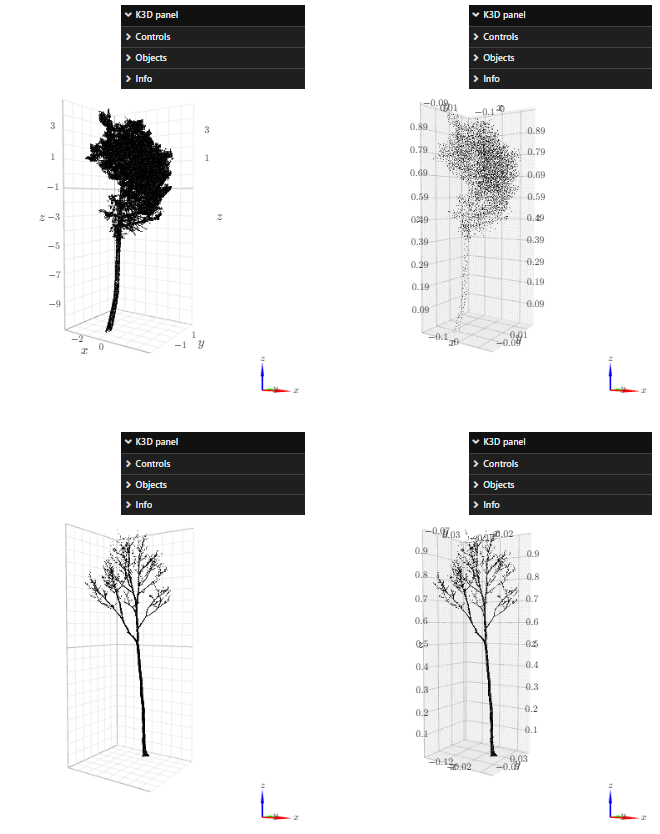 -->
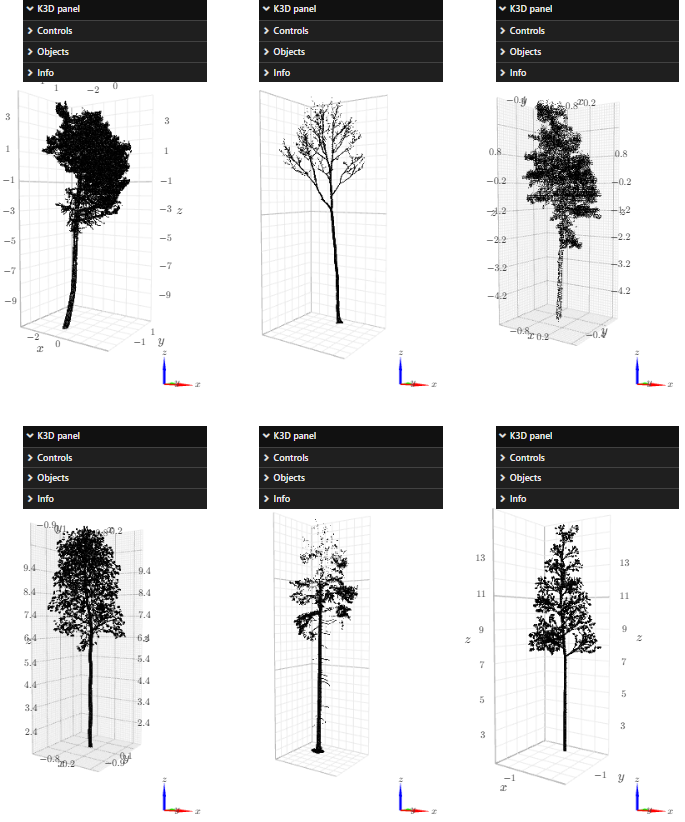

##### Comparison of the first 3 selected point clouds before and after being sampled

In [ ]:
ziped_files = list(zip(selected_n_files[:3], selected_n_sampled_files[:3]))
flattened_files = [item for sublist in ziped_files for item in sublist]

read_comparison_files = load_point_clouds(flattened_files)
plot_point_clouds_next_gen(read_comparison_files, column_count=2) #  file_name="comparison-before-and-after-normalization"

##### Showing all selected (original) point clouds

In [ ]:
read_selected_n_files = load_point_clouds(selected_n_files)
plot_point_clouds_next_gen(read_selected_n_files)   # , file_name="few-original-point-clouds"

### Spliting sampled dataset to TRAIN, VALID and TEST subsets

In [31]:
def split_to_training_validation_and_test_datasets(
        path_folder_file: list, 
        train_proportion=TRAINING_DATA_PROPORTION, valid_proportion=VALIDATION_DATA_PROPORTION,
        species_language=SPECIES_LANGUAGE, 
        ui_language=UI_LANGUAGE,
    ):
    # Load the species names in different languages
    df = pd.read_csv(SPECIES_DATA_CSV_FILENAME, delimiter='\t', encoding='utf-8')

    substring = '_name'
    matching_columns = [col for col in df.columns if substring in col]
    language_columns = [col.replace(substring, '') for col in matching_columns]
    
    if species_language not in language_columns:
        raise ValueError('Language not supported')


    train_paths, valid_paths, test_paths = copy.deepcopy(path_folder_file), copy.deepcopy(path_folder_file), copy.deepcopy(path_folder_file)

    # if False == GENERATE_NEW_CSV_WITH_LIMITED_DATA_SAMPLES:
    #     print("Spliting skipped into training, validation and test datasets.")
    #     return train_paths, valid_paths, test_paths


    # goes through all files
    for i in range(len(train_paths)):
        # Shuffle the path_folder_file list
        np.random.shuffle(train_paths[i][1])

        # Calculate the number of entries for each dataset
        total_entries = len(train_paths[i][1])
        train_entries = round(total_entries * train_proportion)
        valid_entries = int(total_entries * valid_proportion)
        # test_entries = total_entries - train_entries - valid_entries

        # Split the path_folder_file list into train_path, valid_path, and test_path
        test_paths[i][1] = train_paths[i][1][train_entries + valid_entries:]
        valid_paths[i][1]  = train_paths[i][1][train_entries:train_entries + valid_entries]
        train_paths[i][1] = train_paths[i][1][:train_entries]

        # gets correct translation of the species name
        specie_name_latin = train_paths[i][0].split('/')[-1].split('/')[-1]

        if  'latin' == species_language:
            name = specie_name_latin
        else:
            name = df.loc[df['latin_name'] == specie_name_latin, f'{species_language}_name'].values[0]


        print(f"{name}:")
        print(f" - train_path:\t{len(train_paths[i][1])}")
        print(f" - valid_path:\t{len(valid_paths[i][1])}")
        print(f" - test_path:\t{len(test_paths[i][1])}\n")

    return train_paths, valid_paths, test_paths

In [32]:
a, b, c = split_to_training_validation_and_test_datasets(sampled_folder_name_list)

Norway maple:
 - train_path:	24
 - valid_path:	9
 - test_path:	16

Silver birch:
 - train_path:	25
 - valid_path:	10
 - test_path:	15

Small-leaved lime:
 - train_path:	24
 - valid_path:	9
 - test_path:	14

Black pine:
 - train_path:	100
 - valid_path:	40
 - test_path:	60

Maritime pine:
 - train_path:	67
 - valid_path:	26
 - test_path:	41

European red pine:
 - train_path:	100
 - valid_path:	40
 - test_path:	60

Portuguese oak:
 - train_path:	100
 - valid_path:	40
 - test_path:	60

Evergreen oak:
 - train_path:	100
 - valid_path:	40
 - test_path:	60

European beech:
 - train_path:	82
 - valid_path:	32
 - test_path:	50

Norway spruce:
 - train_path:	79
 - valid_path:	31
 - test_path:	48

Douglas fir:
 - train_path:	92
 - valid_path:	36
 - test_path:	55

Northern red oak:
 - train_path:	50
 - valid_path:	20
 - test_path:	30



In [33]:
def display_stacked_bar_chart(
        train_paths, 
        valid_paths, 
        test_paths,
        species_language=SPECIES_LANGUAGE,
        UI_language=UI_LANGUAGE
    ):
    # Load the species names in different languages
    df = pd.read_csv(SPECIES_DATA_CSV_FILENAME, delimiter='\t', encoding='utf-8')

    substring = '_name'
    matching_columns = [col for col in df.columns if substring in col]
    language_columns = [col.replace(substring, '') for col in matching_columns]
    
    if species_language not in language_columns:
        raise ValueError('Language not supported')


    # Extract class names and counts from the paths
    def extract_info(paths):
        counts = [len(path[1]) for path in paths]

        classes = []
        for path in paths:
            specie_name_latin = path[0].split('/')[-1]

            if  'latin' == species_language:
                classes.append(specie_name_latin)
            else:
                classes.append(df.loc[df['latin_name'] == specie_name_latin, f'{species_language}_name'].values[0])

        return classes, counts


    train_classes, train_counts = extract_info(train_paths)
    valid_classes, valid_counts = extract_info(valid_paths)
    test_classes, test_counts = extract_info(test_paths)

    # Ensure that the classes are the same across all subsets
    assert train_classes == valid_classes == test_classes, "Classes are not the same across all subsets"

    # Create an index for each class
    class_indices = np.arange(len(train_classes))


    # Create the bar chart
    plt.figure(figsize=(12, 10))
    plt.rc('font', size=12)         # controls default text sizes


    if 'slovenian' == UI_language:
        plt.bar(class_indices, train_counts, label='Učna množica')
        plt.bar(class_indices, valid_counts, bottom=train_counts, label='Validacijska množica')
        plt.bar(class_indices, test_counts, bottom=np.array(train_counts)+np.array(valid_counts), label='Testna množica')

    elif 'english' == UI_language:
        plt.bar(class_indices, train_counts, label='Train')
        plt.bar(class_indices, valid_counts, bottom=train_counts, label='Validation')
        plt.bar(class_indices, test_counts, bottom=np.array(train_counts)+np.array(valid_counts), label='Test')

    # Add some details to the plot
    if 'slovenian' == UI_language:
        plt.xlabel('Drevesne vrste')
        plt.ylabel('Število posnetkov')
        # plt.title('Porazdelitev podatkov po množicah')
        plt.xticks(class_indices, train_classes, rotation=90)
        plt.legend()
    elif 'english' == UI_language:
        plt.xlabel('Tree species')
        plt.ylabel('Count')
        # plt.title('Data distribution across dataset')
        plt.xticks(class_indices, train_classes, rotation=90)
        plt.legend()

    # # Increase padding
    # plt.subplots_adjust(left=0.15, right=0.95, bottom=0.15, top=0.95)

    # Display the plot
    plt.show()

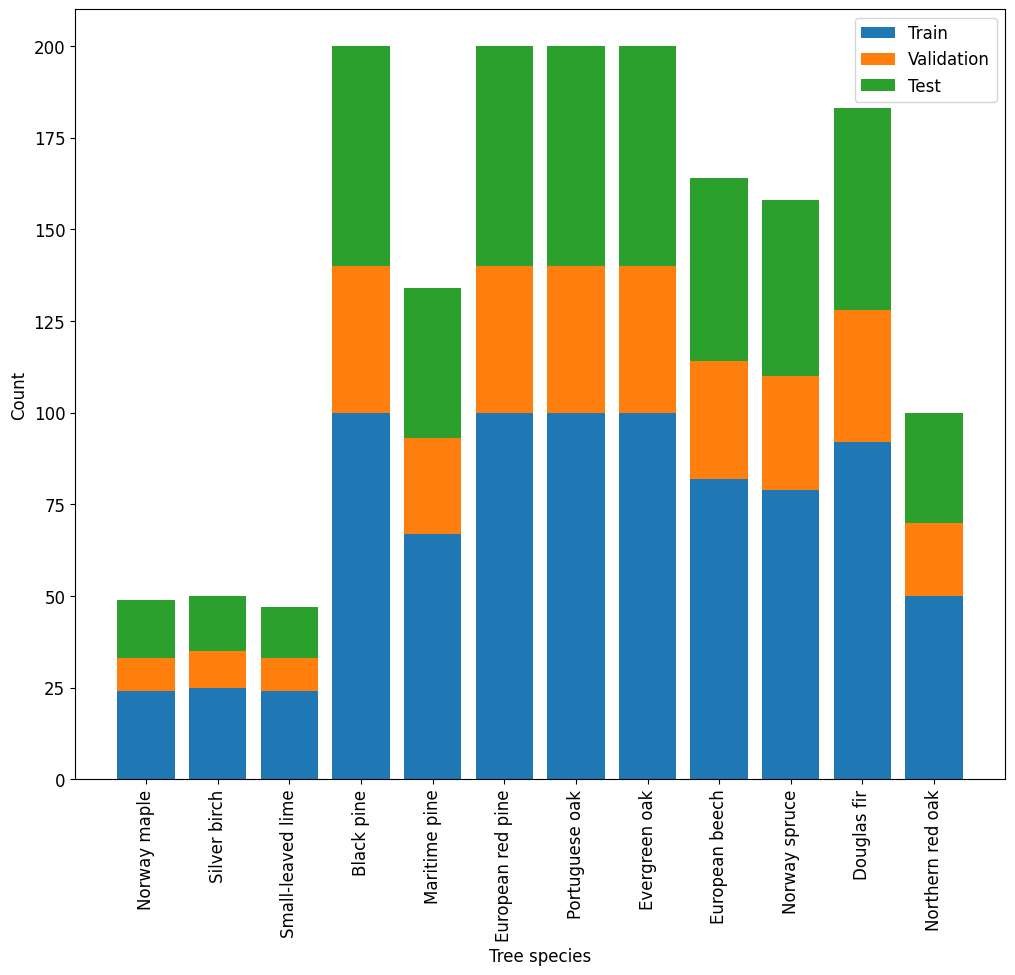

In [34]:
display_stacked_bar_chart(a, b, c)

#### Saving splited set to file which will be used for both neural networks

In [35]:
def save_choosen_data_to_csv(train_path, valid_path, test_path):
    current_time = datetime.now().strftime("%Y.%m.%d %H:%M")

    if False == GENERATE_NEW_CSV_WITH_LIMITED_DATA_SAMPLES:
        print(f"({current_time}): generating of new {CSV_DATASET_FILENAME} skipped...\n")
        return


    header = ['dataset_type', 'path', 'filename', 'species_name']

    with open(CSV_DATASET_FILENAME, 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file, delimiter='\t', quotechar='"', quoting=csv.QUOTE_MINIMAL)
        writer.writerow(header)


        for path, files in train_path:
            for file in files:
                folder_name = path.split('/')[-1]   # this should be species name if you use our data structure
                writer.writerow(['train', path, file, folder_name])
        

        for path, files in valid_path:
            for file in files:
                folder_name = path.split('/')[-1]   # this should be species name if you use our data structure
                writer.writerow(['valid', path, file, folder_name])


        for path, files in test_path:
            for file in files:
                folder_name = path.split('/')[-1]   # this should be species name if you use our data structure
                writer.writerow(['test', path, file, folder_name])


    current_time = datetime.now().strftime("%Y.%m.%d %H:%M")
    print(f"({current_time}): {CSV_DATASET_FILENAME} has been created/updated successfully!\n")

In [ ]:
save_choosen_data_to_csv(a, b, c)

#### Reading created database meta file

In [37]:
TRAIN_FILE_PATHS = []
VALID_FILE_PATHS = []
TEST_FILE_PATHS = []

In [38]:
# Read the CSV file
df = pd.read_csv(CSV_DATASET_FILENAME, delimiter='\t', encoding='utf-8')


train_entries = df[df['dataset_type'] == 'train']
TRAIN_FILE_PATHS = (train_entries['path'] + str(os.sep) + train_entries['filename']).to_list()

valid_entries = df[df['dataset_type'] == 'valid']
VALID_FILE_PATHS = (valid_entries['path'] + str(os.sep) + valid_entries['filename']).to_list()

test_entries = df[df['dataset_type'] == 'test']
TEST_FILE_PATHS = (test_entries['path'] + str(os.sep) + test_entries['filename']).to_list()


# Display the list of file paths
print(f"TRAIN_FILE_PATHS: {TRAIN_FILE_PATHS}\n")
print(f"VALID_FILE_PATHS: {VALID_FILE_PATHS}\n")
print(f"TEST_FILE_PATHS: {TEST_FILE_PATHS}\n")

TRAIN_FILE_PATHS: ['podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_23_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_33_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_0_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_8_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_9_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_41_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_49_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_47_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_42_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_6_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_46_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoides\\ACPL_15_test_cloud.txt', 'podatki - DOWNSAMPLED/Boni Vicari/Acer platanoid